In [1]:
import keras

Using TensorFlow backend.


In [2]:
from Models.functions.plot import plot_history, full_multiclass_report

In [3]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model, Sequential
from Models.functions.preprocessing import clean, labelEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import numpy as np
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
result = pd.DataFrame()

In [4]:
def create_model(filters = [100], kernel_size = [50], strides = [100], 
                 dropout_rate = 0.5, pool_size = [5], dense_units = 100, max_len = 1000):

    model = Sequential()

    # conv 1
    model.add(Conv1D(filters = filters[0], 
                     kernel_size = kernel_size[0],
                     strides = strides[0], 
                     activation = 'relu', 
                     input_shape = (max_len, 1) ))

    # pooling layer 1
    for i in range(len(pool_size)):
        model.add(MaxPooling1D(pool_size = pool_size[i], strides = 1))
        model.add(Activation('relu'))
    
    #model.add(Activation('relu'))
    
    model.add(Flatten())
    
    if dropout_rate is not None:
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(units = dense_units, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'softmax'))

    model.compile(optimizer = 'adadelta', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [5]:


def get_results(model, y_espected, y_predicted):

    config = model.get_config()

    row = {}

    conv_layers = np.sum([1 if i['class_name'] == "Conv1D" else 0 for i in config])
    pooling_layers = np.sum([1 if i['class_name'] == "MaxPooling1D" else 0 for i in config])

    row.update({ '_accuracy': accuracy_score(y_espected, y_predicted) })
    row.update({ '_f1-score': f1_score(y_espected, y_predicted,average='weighted')})
    row.update({ 'conv_layers': conv_layers })
    row.update({ 'pooling_layers': pooling_layers })

    _, _, fscore, support = precision_recall_fscore_support(y_espected, y_predicted)

    [row.update({'_fscore_class_'+str(i[0]): i[1]}) for i in enumerate(fscore)]
    [row.update({'_support_class_'+str(i[0]): i[1]}) for i in enumerate(support)]

    idx = 1
    for i in config:
        if i['class_name'] == "Conv1D":
            j = str(idx)
            row.update({
                'filters_'+j: i['config']['filters'],
                'strides_'+j: i['config']['strides'],
                'kernel_size_'+j: i['config']['kernel_size'],
                'activation_'+j: i['config']['activation']
            })
        pass
    return row

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from Models.functions.datasets import loadTrainTest

X, _, y, _ = loadTrainTest("gender", "brblogset", "/home/rafael/GDrive/Data/Dataframe/")

y, n, classes_names = labelEncoder(y)

vect = TfidfVectorizer(max_features=None)

X_tfidf = vect.fit_transform(X).toarray()

X_tfidf.shape

(2081, 283226)

In [7]:
max_length = np.max([len(x.split(" ")) for x in X])
mean_length = np.mean([len(x.split(" ")) for x in X])
mediam_length = np.median([len(x.split(" ")) for x in X])

print(max_length, mean_length, mediam_length, int(mediam_length))

599293 5537.368572801538 2423.0 2423


### Normalizer

In [8]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import collections, numpy

# Synthetic Minority Oversampling Technique (SMOTE)
def oversampling(X, y):
    #X_resampled, y_resampled = SMOTE().fit_resample(X, y)
    # return X_resampled, y_resampled
    return X, y

X_resampled, y_resampled = oversampling(X_tfidf, y)

collections.Counter(y), collections.Counter(y_resampled)

(Counter({0: 840, 1: 1241}), Counter({0: 840, 1: 1241}))

### Split train and test

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#y_train = to_categorical(y_train, 2)
#y_test = to_categorical(y_test, 2)

X_test.shape, X_train[1].shape

((417, 283226, 1), (283226, 1))

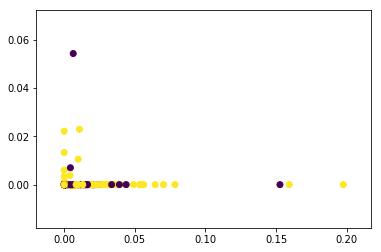

In [10]:

xid, yid = 1, 2
plt.scatter(X_train[:,xid], X_train[:,yid],c=y_train)
#plt.ylabel(classes_names[0])
#plt.ylabel(classes_names[1])

In [ ]:
from time import time

CNN = KerasClassifier(build_fn=create_model, 
                epochs=1,
                max_len=X_train.shape[1],
                #batch_size=BATCH_SIZE,
                verbose=0,
                validation_split=0.1
                )

params_grid = dict(
        filters = [[60]],
        kernel_size = [[50]],
        strides = [[2],[4],[6],[8]],
        dropout_rate = [0.1,0.5,0.6],
        pool_size = [[16,2],[16],[8,2],[8]],
        epochs = [50, 100]
        #batch_size = 100
)              

grid_search = GridSearchCV(CNN, 
                           params_grid, 
                           scoring='accuracy', cv=3, 
                           return_train_score=True
                           )

#print('best params', grid_search.best_params_)


print("Performing grid search...")    
t0 = time()

#histories = []
grid_results = grid_search.fit(X_train, y_train)

print("done in %0.2fs and %0.1fmin" % ((time() - t0), ((time() - t0) / 60) ))
print()

print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
display(pd.DataFrame(grid_search.cv_results_))

Performing grid search...


In [ ]:
params = best_parameters

## create the model with the best params found
model = create_model(filters=params['filters'],
                     kernel_size=params['kernel_size'],
                     strides=params['strides'],
                     dropout_rate=params['dropout_rate'],
                     pool_size=[params['pool_size']]
                    )

## Then train it and display the results
history = model.fit(x_train,
                    y_train,
                    epochs=params['epochs'],
                    validation_split=0.2,
                    #batch_size=params['batch_size'],
                    verbose = 0,
                       callbacks=[
                           #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01),
                           EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
                  ])

model.summary()

directory='/home/rafael/'

plot_history(history, directory=directory)

full_multiclass_report(model,
                       x_test,
                       y_test,
                       classes=classes_names,
                       directory=directory
                      )
                       #batch_size=32,
                       #binary= )
        
        
#result = result
# get_results(model, y_test, model.predict_classes(X_test))

In [ ]:
y_pred = model.predict_classes(x_test)
accuracy_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)